In [2]:
import os
import glob
import operator  as op
import functools as ft

import numpy             as np
import matplotlib.pyplot as plt

from CCutils import lmap
from CCutils import npmap
from CCfun   import in_range
from CCfun   import compute_baseline_float
from CCfun   import datetime_from_spectrum
from CCfun   import power_to_quanta_rate

from CCplot  import plot1d
from CCplot  import plot_line
from CCplot  import auto_plot_style
from CCplot  import figure_sizes
from CCplot  import subplots

from CCfit   import shifted_gauss
from CCfit   import shifted_triple_gauss
from CCfit   import fit

from CCio    import load_ccd_file

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
maindir = "/home/gonzalo/data/CC/caf_conversion/"

auto_plot_style({"lines.markersize" : 10})

peaks  = {"600"  : 770,
          "410_0": 580,
          "410_1": 770,
          "400_0": 580,
          "400_1": 770,
          "350_0": 420,
          "350_1": (630, 700, 770)}

ranges = {"600"  : (625, 925),
          "410_0": (400, 625),
          "410_1": (625, 925),
          "400_0": (400, 625),
          "400_1": (625, 925),
          "350_0": (395, 500),
          "350_1": (595, 900)}

models = {"600"  : shifted_gauss,
          "410_0": shifted_gauss,
          "410_1": shifted_gauss,
          "400_0": shifted_gauss,
          "400_1": shifted_gauss,
          "350_0": shifted_gauss,
          "350_1": shifted_triple_gauss}


seeds = {"600"  : (1e3, 770, 30,                             0),
         "410_0": (1e3, 580, 30,                             0),
         "410_1": (1e3, 770, 30,                             0),
         "400_0": (1e3, 580, 30,                             0),
         "400_1": (1e3, 770, 30,                             0),
         "350_0": (1e3, 420, 30,                             0),
         "350_1": (1e3, 630, 50, 1e3, 700, 30, 1e3, 770, 70, 0)}

In [10]:
def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 900)
    return y[m].max()

def sum_(x, y):
    m  = in_range(x, 600, 900)
    return y[m].sum()

def integrate(emwl, spectrum, exwl, peak, range, rebin_by=1, plot=False):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    y  = y[x > exwl + 30]
    x  = x[x > exwl + 30]

    s  = find_max(x, y), peak,  30,  0
    f  = fit(shifted_gauss, x, y, s, fit_range = range, maxfev=int(1e6))
    if plot:
        plt.figure()
        plt.plot(x, y, "k.")
        plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def analyze(filenames, exwl, peak, range, plot=False):
    datas     =  lmap(load_ccd_file, filenames)
    em_wls    =  lmap(op.attrgetter("em_wl"), datas)
    times     = npmap(datetime_from_spectrum, datas)
    t0        = times[0]
    times     = npmap(op.attrgetter("seconds"), times - t0) * 1.0
    spectra   = [s.rate / power_to_quanta_rate(s.power.mean, exwl) for s in datas]
    integrals = npmap(ft.partial(integrate, exwl=exwl, peak=peak, range=range, plot=plot), em_wls, spectra)
    return t0.timestamp(), times, integrals

# Fit

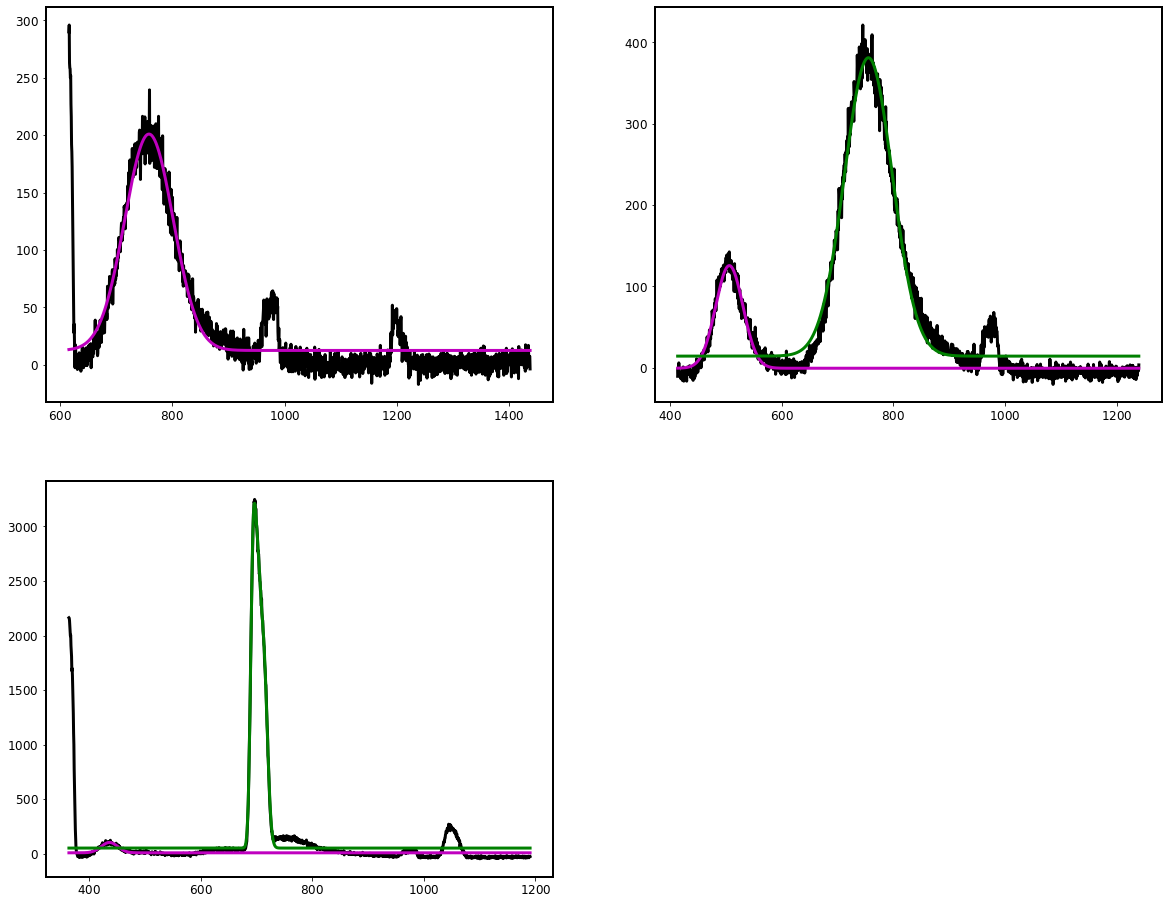

In [11]:
filenames_600 = sorted(glob.glob(os.path.join(maindir, "600", "*_600_*signal.asc")), key=orderer)
filenames_400 = sorted(glob.glob(os.path.join(maindir, "400", "*_400_*signal.asc")), key=orderer)
filenames_350 = sorted(glob.glob(os.path.join(maindir, "350", "*_350_*signal.asc")), key=orderer)

plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
ccd  = load_ccd_file(filenames_600[0])
x, y = ccd.em_wl, ccd.rate
f    = fit(models            ["600"],
           x, y,
           seeds             ["600"],
           fit_range = ranges["600"],
           maxfev    = int(1e6))
plt.plot(x, y)
plt.plot(x, f.fn(x))

plt.subplot(2, 2, 2)
ccd  = load_ccd_file(filenames_400[0])
x, y = ccd.em_wl, ccd.rate

plt.plot(x, y)
for i in range(2):
    f    = fit(models            [f"400_{i}"],
               x, y,
               seeds             [f"400_{i}"],
               fit_range = ranges[f"400_{i}"],
               maxfev    = int(1e6))
    plt.plot(x, f.fn(x))

plt.subplot(2, 2, 3)
ccd  = load_ccd_file(filenames_350[0])
x, y = ccd.em_wl, ccd.rate
plt.plot(x, y)
for i in range(2):
    f    = fit(models            [f"350_{i}"],
               x, y,
               seeds             [f"350_{i}"],
               fit_range = ranges[f"350_{i}"],
               maxfev    = int(1e6))
    plt.plot(x, f.fn(x))

# Conversion between 600/770 and 400/770

In [4]:
integrals = []
filenames_600 = sorted(glob.glob(os.path.join(maindir, "600_400", "*_600_*signal.asc")), key=orderer)
filenames_400 = sorted(glob.glob(os.path.join(maindir, "600_400", "*_400_*signal.asc")), key=orderer)
t0_600, times_600, integrals_600 = analyze(filenames_600, 600)
t0_400, times_400, integrals_400 = analyze(filenames_400, 400)

In [5]:
times_400 += t0_400 - t0_600

Text(0, 0.5, 'Integral')

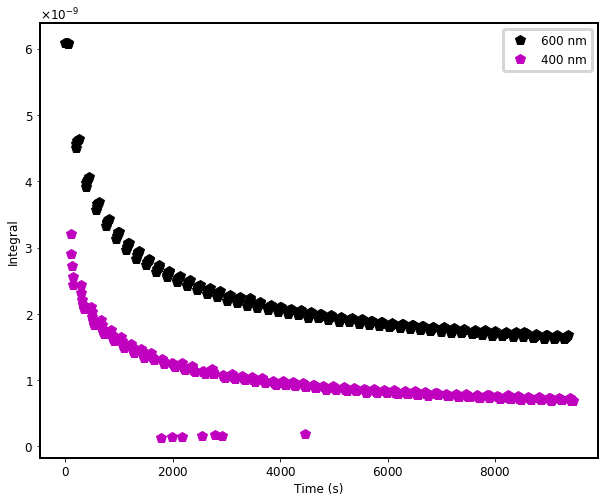

In [6]:
plt.plot(times_600, integrals_600, "p", label="600 nm")
plt.plot(times_400, integrals_400, "p", label="400 nm")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral')

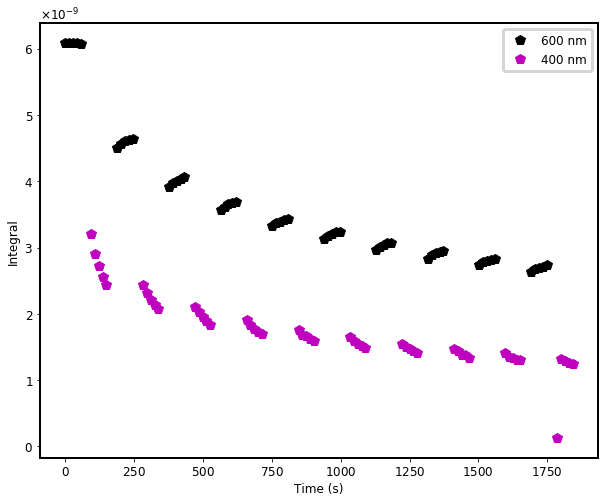

In [7]:
plt.plot(times_600[:50], integrals_600[:50], "p", label="600 nm")
plt.plot(times_400[:50], integrals_400[:50], "p", label="400 nm")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral 400')

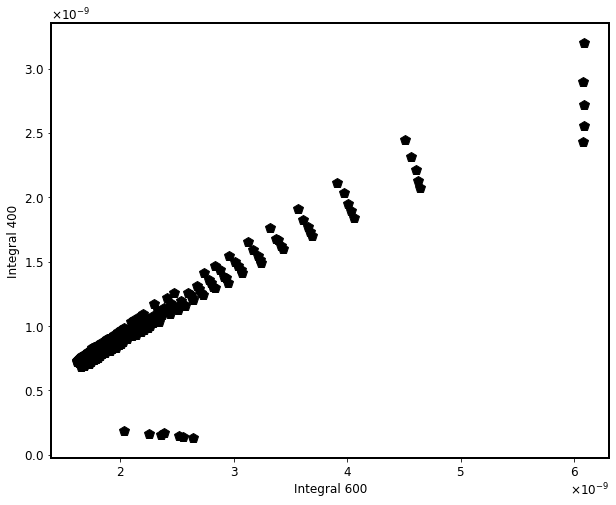

In [8]:
plt.plot(integrals_600, integrals_400, "p")
plt.xlabel("Integral 600")
plt.ylabel("Integral 400")

Text(0, 0.5, 'Integral 600 / Integral 400')

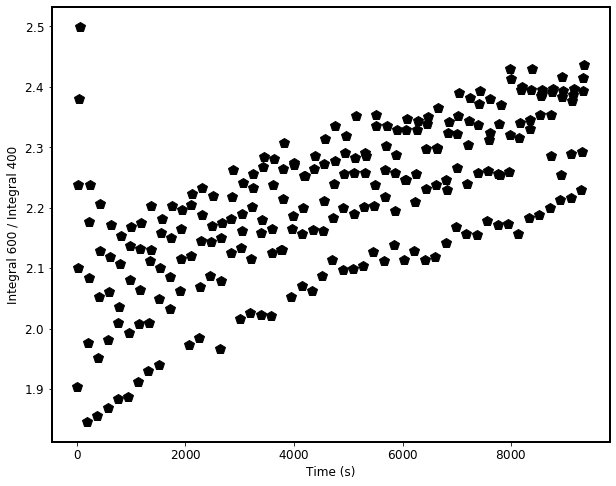

In [9]:
plt.plot(times_600, np.where(integrals_400 > 0.5e-9, integrals_600/integrals_400, np.nan), "p")
plt.xlabel("Time (s)")
plt.ylabel("Integral 600 / Integral 400")

# Conversion between 600/770 and 350/630

In [10]:
integrals = []
filenames_600 = sorted(glob.glob(os.path.join(maindir, "600_350", "*_600_*signal.asc")), key=orderer)
filenames_350 = sorted(glob.glob(os.path.join(maindir, "600_350", "*_350_*signal.asc")), key=orderer)
t0_600, times_600, integrals_600 = analyze(filenames_600, 600)
t0_350, times_350, integrals_350 = analyze(filenames_350, 350)

In [11]:
times_350 += t0_350 - t0_600

Text(0, 0.5, 'Integral')

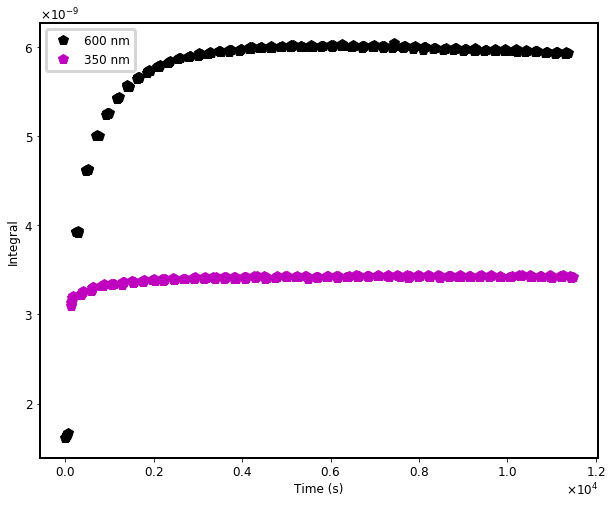

In [12]:
plt.plot(times_600, integrals_600, "p", label="600 nm")
plt.plot(times_350, integrals_350, "p", label="350 nm")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral')

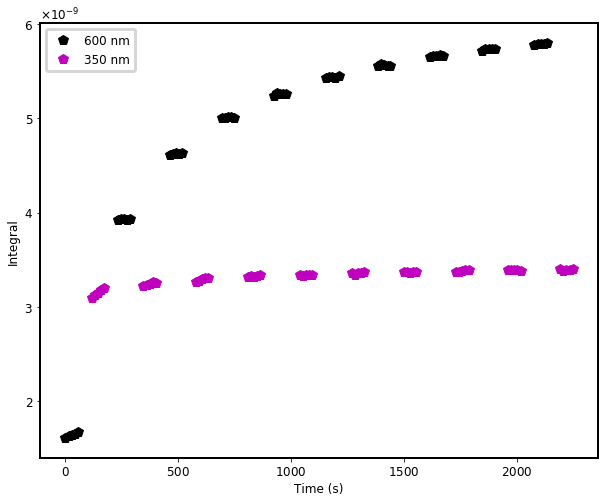

In [13]:
plt.plot(times_600[:50], integrals_600[:50], "p", label="600 nm")
plt.plot(times_350[:50], integrals_350[:50], "p", label="350 nm")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral 350')

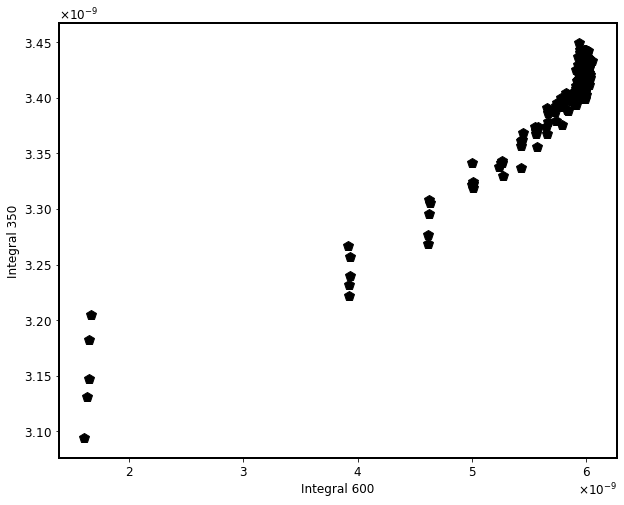

In [14]:
plt.plot(integrals_600, integrals_350, "p")
plt.xlabel("Integral 600")
plt.ylabel("Integral 350")

Text(0, 0.5, 'Integral 600 / Integral 350')

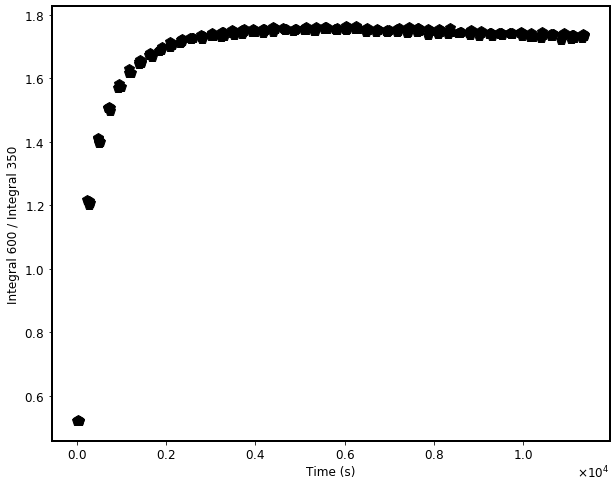

In [15]:
plt.plot(times_600, integrals_600/integrals_350, "p")
plt.xlabel("Time (s)")
plt.ylabel("Integral 600 / Integral 350")

# Conversion between 400/770 and 350/630

In [16]:
integrals = []
filenames_400 = sorted(glob.glob(os.path.join(maindir, "400_350", "*_400_*signal.asc")), key=orderer)
filenames_350 = sorted(glob.glob(os.path.join(maindir, "400_350", "*_350_*signal.asc")), key=orderer)
t0_400, times_400, integrals_400 = analyze(filenames_400, 400)
t0_350, times_350, integrals_350 = analyze(filenames_350, 350)

In [17]:
times_350 += t0_350 - t0_400

Text(0, 0.5, 'Integral')

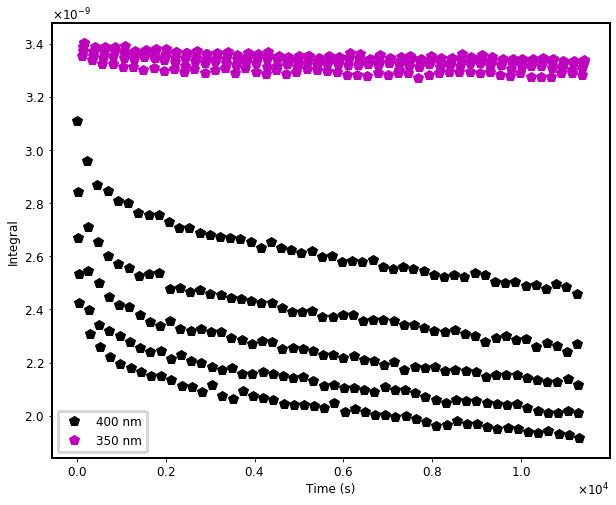

In [18]:
plt.plot(times_400, integrals_400, "p", label="400 nm")
plt.plot(times_350, integrals_350, "p", label="350 nm")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral')

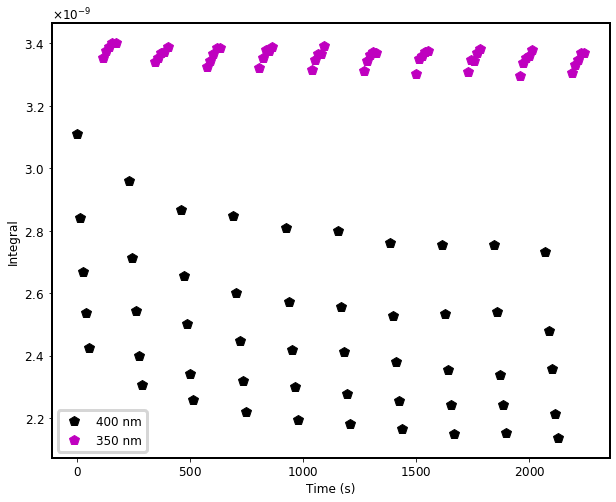

In [19]:
plt.plot(times_400[:50], integrals_400[:50], "p", label="400 nm")
plt.plot(times_350[:50], integrals_350[:50], "p", label="350 nm")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral 350')

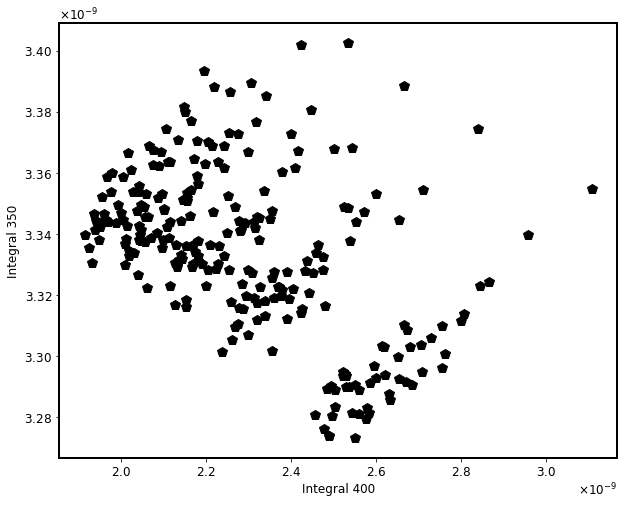

In [20]:
plt.plot(integrals_400, integrals_350, "p")
plt.xlabel("Integral 400")
plt.ylabel("Integral 350")

Text(0, 0.5, 'Integral 400 / Integral 350')

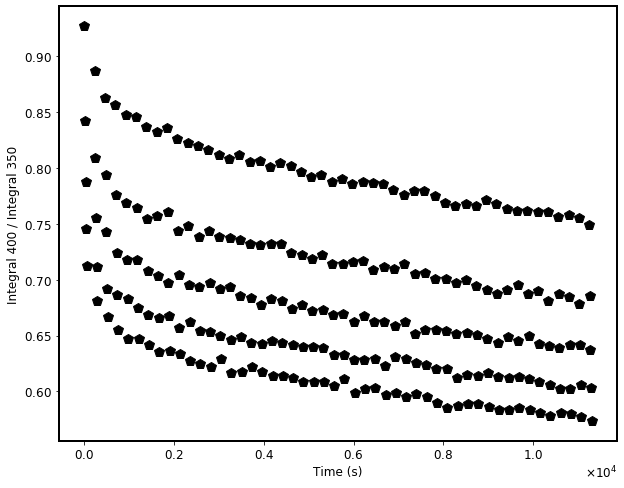

In [21]:
plt.plot(times_400, integrals_400/integrals_350, "p")
plt.xlabel("Time (s)")
plt.ylabel("Integral 400 / Integral 350")

# No bleachings

In [45]:
filenames_600 = sorted(glob.glob(os.path.join(maindir, "600", "*_600_*signal.asc")), key=orderer)
filenames_400 = sorted(glob.glob(os.path.join(maindir, "400", "*_400_*signal.asc")), key=orderer)
filenames_350 = sorted(glob.glob(os.path.join(maindir, "350", "*_350_*signal.asc")), key=orderer)
t0_600_nb, times_600_nb, integrals_600_nb = analyze(filenames_600, 600)
t0_400_nb, times_400_nb, integrals_400_nb = analyze(filenames_400, 400)
t0_350_nb, times_350_nb, integrals_350_nb = analyze(filenames_350, 350)

Text(0, 0.5, 'Integral')

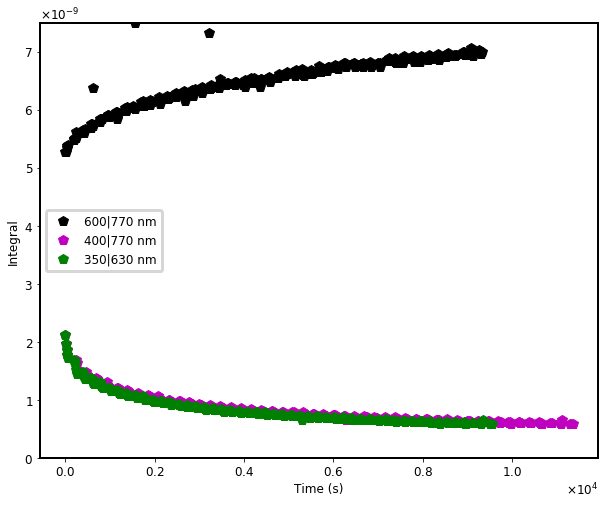

In [46]:
plt.plot(times_600_nb, integrals_600_nb, "p", label="600|770 nm")
plt.plot(times_400_nb, integrals_400_nb, "p", label="400|770 nm")
plt.plot(times_350_nb, integrals_400_nb, "p", label="350|630 nm")
plt.legend()
plt.ylim(0, np.max(integrals_600_nb))
plt.xlabel("Time (s)")
plt.ylabel("Integral")

Text(0, 0.5, 'Integral')

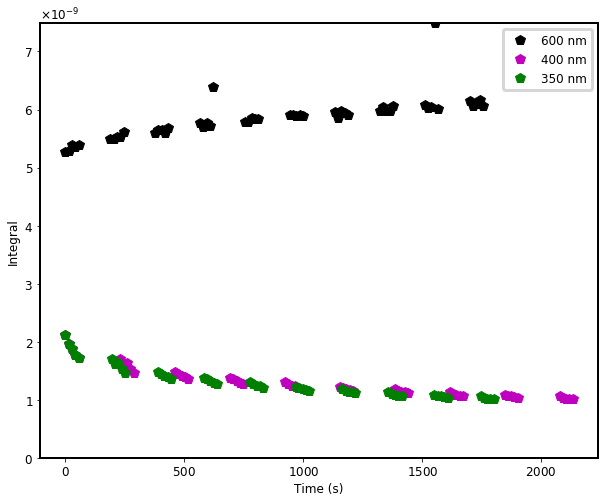

In [47]:
plt.plot(times_600_nb[:50], integrals_600_nb[:50], "p", label="600 nm")
plt.plot(times_400_nb[:50], integrals_400_nb[:50], "p", label="400 nm")
plt.plot(times_350_nb[:50], integrals_400_nb[:50], "p", label="350 nm")
plt.legend()
plt.ylim(0, np.max(integrals_600_nb))
plt.xlabel("Time (s)")
plt.ylabel("Integral")